les imports

In [1]:
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    roc_curve
)

import matplotlib.pyplot as plt

chargement 

In [2]:
movies_raw = pd.read_csv("movies_metadata.csv")
ratings_raw=pd.read_csv("ratings_small.csv")

/var/folders/26/vjhzs_md5jg6_bczm_n_6mn40000gn/T/ipykernel_11445/4046811596.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies_raw = pd.read_csv("movies_metadata.csv")


nettoyage movies_metadata.csv

In [3]:
movies_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

In [4]:
movies_raw.isna().sum()

adult                        0
belongs_to_collection    40972
budget                       0
genres                       0
homepage                 37684
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   5
poster_path                386
production_companies         3
production_countries         3
release_date                87
revenue                      6
runtime                    263
spoken_languages             6
status                      87
tagline                  25054
title                        6
video                        6
vote_average                 6
vote_count                   6
dtype: int64

In [5]:
assert "id" in movies_raw.columns and "title"

In [6]:
movies_raw=movies_raw.dropna(subset=["title"])

In [7]:
movies_raw.isna().sum()

adult                        0
belongs_to_collection    40970
budget                       0
genres                       0
homepage                 37682
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   0
poster_path                383
production_companies         0
production_countries         0
release_date                84
revenue                      0
runtime                    257
spoken_languages             0
status                      81
tagline                  25048
title                        0
video                        0
vote_average                 0
vote_count                   0
dtype: int64

garder id+title &&
id(object)->movieId(numeric)

In [8]:
movies=movies_raw[["id","title"]].copy()
movies["movieId"]=pd.to_numeric(movies["id"], errors="coerce")
movies=movies.dropna(subset=["movieId"])
movies["movieId"]=movies["movieId"].astype("int64")
movies=movies[["movieId","title"]]

In [9]:
movies.isna().sum()

movieId    0
title      0
dtype: int64

In [10]:
print("movies apres nettoyage :", len(movies))
movies.head(10)

movies apres nettoyage : 45460


,movieId,title
0,862,Toy Story
1,8844,Jumanji
2,15602,Grumpier Old Men
3,31357,Waiting to Exhale
4,11862,Father of the Bride Part II
5,949,Heat
6,11860,Sabrina
7,45325,Tom and Huck
8,9091,Sudden Death
9,710,GoldenEye


nettoyage ratings

In [11]:
ratings_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [12]:
ratings_raw.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [13]:
ratings= ratings_raw[["userId","movieId","rating", "timestamp"]]
print(ratings.dtypes)


userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object


verifier les doublons

In [14]:
duplicates=ratings[ratings.duplicated(subset=["userId","movieId"],keep=False)]
print("nombre des doublons:", len(duplicates))
duplicates.head(10)
print("Total des lignes :", len(ratings))
print("Total des combinaisons uniques :", ratings[["userId", "movieId"]].drop_duplicates().shape[0])


nombre des doublons: 0
Total des lignes : 100004
Total des combinaisons uniques : 100004


creer le label binaire

In [15]:
THRESHOLD = 4.0 # à partir de 4 étoiles = "il aime"

ratings=ratings.dropna(subset=["userId","movieId","rating","timestamp"])
ratings["label"]=(ratings["rating"]>=THRESHOLD).astype(int)
print(ratings.head())

   userId  movieId  rating   timestamp  label
0       1       31     2.5  1260759144      0
1       1     1029     3.0  1260759179      0
2       1     1061     3.0  1260759182      0
3       1     1129     2.0  1260759185      0
4       1     1172     4.0  1260759205      1


In [16]:
print ( "ratings apres nettoyage:" ,len(ratings))
ratings.info()


ratings apres nettoyage: 100004
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
 4   label      100004 non-null  int64  
dtypes: float64(1), int64(4)
memory usage: 3.8 MB


#  Modèle 1 – Régression Logistique

4-construire x et y +entrainer le model 

In [17]:
# One-Hot sur (userId, movieId)
enc= OneHotEncoder(handle_unknown="ignore",dtype=float)
X=enc.fit_transform(ratings[["userId","movieId"]])
y=ratings["label"].to_numpy()

In [18]:
# Train / Test
X_train , X_test , y_train ,y_test=train_test_split(X,y, test_size=0.1,random_state=42,stratify=y)

clf=LogisticRegression(solver="liblinear",
                       max_iter=200,
                       class_weight="balanced")
clf.fit(X_train,y_train)
probs=clf.predict_proba(X_test)[:, 1]
preds=(probs>=0.5).astype(int)



5-evaluer le modele 

In [19]:
acc=accuracy_score(y_test,preds)
prec,rec,f1,_=precision_recall_fscore_support(y_test,preds,average="binary",zero_division=0)
auc_score = roc_auc_score(y_test,probs)
print ( "perfermance de modele:")
print(f"accuracy: {acc:.4f}")
print(f"precision: {prec:.4f}")
print(f"f1-score: {f1:.4f}")
print(f"recall: {rec:.4f}")
print(f"Auc: {auc_score:.4f}")

perfermance de modele:
accuracy: 0.7202
precision: 0.7285
f1-score: 0.7288
recall: 0.7291
Auc: 0.7933


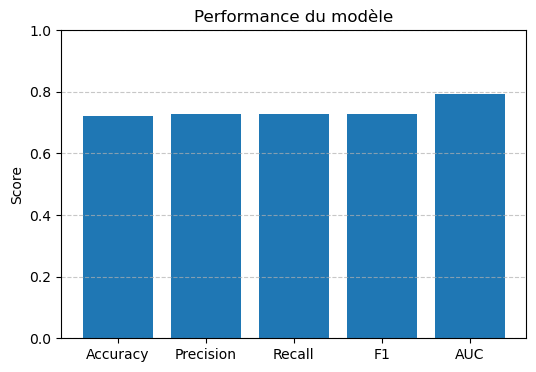

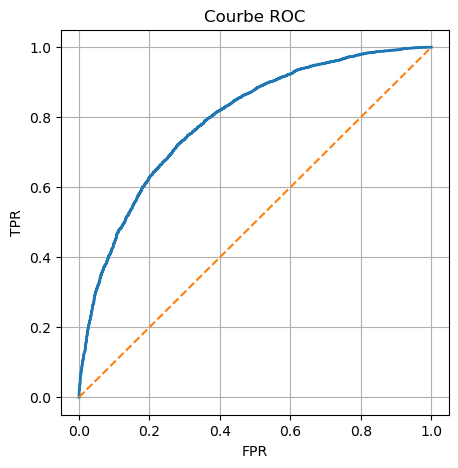

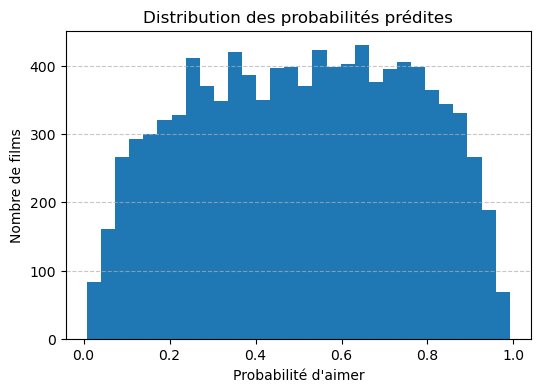

In [20]:
# 1) Barres des métriques
metrics = ["Accuracy", "Precision", "Recall", "F1", "AUC"]
scores = [acc, prec, rec, f1, auc_score]

plt.figure(figsize=(6,4))
plt.bar(metrics, scores)
plt.ylim(0, 1)
plt.title("Performance du modèle")
plt.ylabel("Score")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# 2) Courbe ROC
fpr, tpr, _ = roc_curve(y_test, probs)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.title("Courbe ROC")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.grid(True)
plt.show()

# 3) Histogramme des probabilités
plt.figure(figsize=(6,4))
plt.hist(probs, bins=30)
plt.title("Distribution des probabilités prédites")
plt.xlabel("Probabilité d'aimer")
plt.ylabel("Nombre de films")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


recommendation pour un utilisateur 

In [21]:
# film déjà vus par chaque utilisateur 
def movies_seen(df):
    """
    userId -> set(movieId déjà notés)
    """
    seen = {}
    for _, row in df.iterrows():
        user = int(row["userId"])
        movie = int(row["movieId"])
        if user not in seen:
            seen[user] = set()
        seen[user].add(movie)
    return seen

# ⚠️ ICI : utiliser ratings, pas dr
seen_dict = movies_seen(ratings)

print("Nombre d'utilisateurs :", len(seen_dict))
print("Exemple de contenu :")

# afficher les 3 premiers utilisateurs
for user_id, movies_list in list(seen_dict.items())[:3]:
    print(f"Utilisateur {user_id} a noté {len(movies_list)} films : {list(movies_list)[:5]} ...")


Nombre d'utilisateurs : 671
Exemple de contenu :
Utilisateur 1 a noté 20 films : [1029, 1287, 1293, 2193, 1172] ...
Utilisateur 2 a noté 76 films : [509, 515, 261, 265, 10] ...
Utilisateur 3 a noté 51 films : [2694, 778, 267, 84236, 2318] ...


In [22]:


def recommend_logistic_for_user(user_id, clf, enc, ratings, movies, topk=10, min_prob=0.5):
    """
    Modèle 1 : Recommandation avec la régression logistique
    Retourne les topk films les plus probables d'être aimés par user_id.
    """
    user_id = int(user_id)

    # 1) Vérifier que l'utilisateur existe
    if user_id not in ratings["userId"].unique():
        print(f"userId {user_id} n'existe pas.")
        return None

    # 2) Films déjà notés par cet utilisateur
    seen = set(ratings[ratings["userId"] == user_id]["movieId"])
    all_movies = movies["movieId"].dropna().astype(int).unique()

    # 3) Candidats = films non vus
    candidates = [m for m in all_movies if m not in seen]
    if not candidates:
        print("⚠️ Aucun film candidat : il a déjà tout noté.")
        return None

    candidates = np.array(candidates, dtype=int)

    # 4) Encodage OneHot
    df_cand = pd.DataFrame({
        "userId": np.full_like(candidates, user_id),
        "movieId": candidates
    })
    X_cand = enc.transform(df_cand[["userId", "movieId"]])

    # 5) Prédiction des probabilités
    probs = clf.predict_proba(X_cand)[:, 1]

    # 6) Sélection des topk
    order = np.argsort(-probs)[:topk]
    top_ids = candidates[order]
    top_probs = probs[order]

    recs = pd.DataFrame({
        "movieId": top_ids,
        "score_log": top_probs
    })

    movies_clean = movies.copy()
    movies_clean["movieId"] = movies_clean["movieId"].astype(int)
    recs = recs.merge(movies_clean, on="movieId", how="left")

    return recs



# M2 – Filtrage Collaboratif (SVD)

In [23]:
print(ratings.head())
print(ratings.dtypes)

   userId  movieId  rating   timestamp  label
0       1       31     2.5  1260759144      0
1       1     1029     3.0  1260759179      0
2       1     1061     3.0  1260759182      0
3       1     1129     2.0  1260759185      0
4       1     1172     4.0  1260759205      1
userId         int64
movieId        int64
rating       float64
timestamp      int64
label          int64
dtype: object


In [24]:
print(movies.head())
print(movies.dtypes)

   movieId                        title
0      862                    Toy Story
1     8844                      Jumanji
2    15602             Grumpier Old Men
3    31357            Waiting to Exhale
4    11862  Father of the Bride Part II
movieId     int64
title      object
dtype: object


In [25]:
! pip install scikit-surprise

In [26]:
from surprise import Dataset, Reader, SVD
print("scikit-surprise fonctionne !")

scikit-surprise fonctionne !


In [27]:
# 1) Définir l'échelle des notes
reader = Reader(rating_scale=(0.5, 5.0))

# 2) Convertir ratings (Pandas -> Surprise)
data = Dataset.load_from_df(ratings[["userId", "movieId", "rating"]], reader)

# 3) Construire le trainset complet
trainset = data.build_full_trainset()

# 4) Créer le modèle SVD
svd = SVD(
    n_factors=50,     # nombre de "caractéristiques cachées"
    n_epochs=20,      # nombre de passes d'apprentissage
    random_state=42
)

# 5) Entraîner
svd.fit(trainset)

print(" Modèle SVD entraîné (Filtrage collaboratif).")

 Modèle SVD entraîné (Filtrage collaboratif).


tester une prediction

In [28]:
test_user = 1
test_movie = 15602  # choisis un movieId existant

pred = svd.predict(test_user, test_movie)
print(pred)
print(f"Note prédite pour user {test_user} sur film {test_movie} : {pred.est:.2f}")


user: 1          item: 15602      r_ui = None   est = 2.64   {'was_impossible': False}
Note prédite pour user 1 sur film 15602 : 2.64


In [29]:


def recommend_cf(user_id, svd_model, ratings, movies, topk=10):
    user_id = int(user_id)

    # 1) vérifier que l'user existe
    if user_id not in ratings["userId"].unique():
        print(f"⚠️ userId {user_id} n'existe pas dans ratings.")
        return None

    # 2) films déjà notés par cet user
    seen_movies = set(ratings[ratings["userId"] == user_id]["movieId"])

    # 3) tous les films possibles
    all_movies = movies["movieId"].unique()

    # 4) candidats = films pas encore vus
    candidates = [m for m in all_movies if m not in seen_movies]
    if not candidates:
        print("⚠️ Aucun film candidat (il a déjà tout vu).")
        return None

    # 5) prédire une note pour chaque candidat
    preds = []
    for m in candidates:
        est = svd_model.predict(user_id, int(m)).est  # note prédite entre 0.5 et 5
        preds.append((m, est))

    # 6) trier par note prédite décroissante
    preds_sorted = sorted(preds, key=lambda x: x[1], reverse=True)[:topk]

    # 7) construire un DataFrame avec les titres
    top_movie_ids = [p[0] for p in preds_sorted]
    top_scores = [p[1] for p in preds_sorted]

    recs = pd.DataFrame({
        "movieId": top_movie_ids,
        "score_pred": top_scores
    }).merge(movies, on="movieId", how="left")

    return recs


Tester la reco CF pour un utilisateur

In [30]:
user_test = 1  
recs_cf = recommend_cf(user_test, svd, ratings, movies, topk=10)

recs_cf


,movieId,score_pred,title
0,318,3.711004,The Million Dollar Hotel
1,913,3.578368,The Thomas Crown Affair
2,858,3.556689,Sleepless in Seattle
3,527,3.549324,Once Were Warriors
4,6016,3.535250,The Good Thief
5,922,3.533517,Dead Man
6,926,3.523926,Galaxy Quest
7,994,3.501336,Straw Dogs
8,5995,3.496631,Miffo
9,912,3.492649,The Thomas Crown Affair


Comparer plusieurs utilisateurs

In [31]:
for user_id in [1, 5, 10]:
    recs = recommend_cf(user_id, svd, ratings, movies, topk=5)
    print(f"\n🎬 Recommandations pour l'utilisateur {user_id}:")
    print(recs[["title", "score_pred"]])



🎬 Recommandations pour l'utilisateur 1:
                      title  score_pred
0  The Million Dollar Hotel    3.711004
1   The Thomas Crown Affair    3.578368
2      Sleepless in Seattle    3.556689
3        Once Were Warriors    3.549324
4            The Good Thief    3.535250

🎬 Recommandations pour l'utilisateur 5:
           title  score_pred
0   Galaxy Quest    4.792305
1          Crank    4.724315
2  Lonely Hearts    4.683873
3     Straw Dogs    4.677147
4  Pandora's Box    4.660508

🎬 Recommandations pour l'utilisateur 10:
                                               title  score_pred
0                               Sleepless in Seattle    4.525704
1                                    Men in Black II    4.476391
2                                               Nell    4.474162
3                                      Pandora's Box    4.432112
4  Shriek If You Know What I Did Last Friday the ...    4.410609


# le modèle hybride

In [32]:
import numpy as np
import pandas as pd

def hybrid_recommend_for_user(user_id,
                              clf,
                              enc,
                              svd_model,
                              ratings,
                              movies,
                               seen_dict,
                              topk=10,
                              alpha=0.5):
    """
    Modèle hybride:
    - alpha : poids du modèle logistique (entre 0 et 1)
    - (1 - alpha) : poids du filtrage collaboratif SVD
    Retourne topk films non vus par user_id.
    """
    user_id = int(user_id)

    # 1) vérifier que l'user existe
    if user_id not in ratings["userId"].unique():
        print(f"⚠️ userId {user_id} n'existe pas.")
        return None

    # 2) films déjà notés
    seen_dict=seen_dict,

    # 3) tous les films disponibles
    all_movies = movies["movieId"].dropna().astype(int).unique()

    # 4) candidats = films pas encore vus
    candidates = [m for m in all_movies if m not in seen]
    if not candidates:
        print("⚠️ Aucun film candidat.")
        return None

    candidates = np.array(candidates, dtype=int)

    # --------- Score 1 : modèle logistique ---------
    df_cand = pd.DataFrame({
        "userId": np.full_like(candidates, user_id),
        "movieId": candidates
    })

    X_cand = enc.transform(df_cand[["userId", "movieId"]])
    probs_log = clf.predict_proba(X_cand)[:, 1]   # déjà entre 0 et 1

    # --------- Score 2 : modèle SVD (notes prédites) ---------
    probs_svd = []
    for m in candidates:
        est = svd_model.predict(user_id, int(m)).est  # entre 0.5 et 5.0
        # normaliser en [0,1]
        p = (est - 0.5) / (5.0 - 0.5)
        p = max(0.0, min(1.0, p))  # sécurité
        probs_svd.append(p)
    probs_svd = np.array(probs_svd)

    # --------- Combinaison hybride ---------
    # alpha * proba_logistique + (1 - alpha) * proba_CF
    scores = alpha * probs_log + (1.0 - alpha) * probs_svd

    # --------- Top-K ---------
    order = np.argsort(-scores)[:topk]
    top_ids = candidates[order]
    top_scores = scores[order]

    recs = pd.DataFrame({
        "movieId": top_ids,
        "score_hybride": top_scores
    })

    # ajouter le titre
    movies_clean = movies.copy()
    movies_clean["movieId"] = movies_clean["movieId"].astype(int)

    recs = recs.merge(movies_clean, on="movieId", how="left")

    return recs


tester 

In [33]:
user_test = 1  # tu peux essayer 1, 2, 5, etc.

recs_hybrid = hybrid_recommend_for_user(
    user_id=user_test,
    clf=clf,
    enc=enc,
    svd_model=svd,
    ratings=ratings,
    movies=movies,
    seen_dict=seen_dict,
    topk=10,
    alpha=0.5  # 50% logistique, 50% CF
)

recs_hybrid


NameError: name 'seen' is not defined

# comparison entre M1 M2 et M3

In [ ]:
user_test = 1

recs_log = recommend_logistic_for_user(user_test, clf, enc, ratings, movies, topk=10, min_prob=0.5)
recs_cf  = recommend_cf(user_test, svd, ratings, movies, topk=10)
recs_hyb = hybrid_recommend_for_user(user_test, clf, enc, svd, ratings, movies, seen_dict, topk=10, alpha=0.5)

print("=== M1 : Logistique ===")
display(recs_log[["title", "score_log"]])

print("=== M2 : CF SVD ===")
display(recs_cf[["title", "score_pred"]])

print("=== M3 : Hybride ===")
display(recs_hyb[["title", "score_hybride"]])



=== M1 : Logistique ===


,title,score_log
0,Sleepless in Seattle,0.644959
1,Amélie,0.633407
2,While You Were Sleeping,0.626481
3,The Million Dollar Hotel,0.623199
4,Frankenstein,0.597210
5,Yella,0.589942
6,Mission: Impossible,0.561464
7,The Good Thief,0.550988
8,Lonely Hearts,0.531681
9,Pandora's Box,0.524410


=== M2 : CF SVD ===


,title,score_pred
0,The Million Dollar Hotel,3.711004
1,The Thomas Crown Affair,3.578368
2,Sleepless in Seattle,3.556689
3,Once Were Warriors,3.549324
4,The Good Thief,3.535250
5,Dead Man,3.533517
6,Galaxy Quest,3.523926
7,Straw Dogs,3.501336
8,Miffo,3.496631
9,The Thomas Crown Affair,3.492649


=== M3 : Hybride ===


,title,score_hybride
0,The Million Dollar Hotel,0.668378
1,Sleepless in Seattle,0.662112
2,While You Were Sleeping,0.641818
3,Amélie,0.625320
4,The Good Thief,0.612744
5,Frankenstein,0.612733
6,Once Were Warriors,0.599887
7,Lonely Hearts,0.595974
8,Pandora's Box,0.591915
9,Mission: Impossible,0.591250


In [ ]:
# normaliser le score CF sur [0,1] pour comparaison visuelle
recs_cf_norm = recs_cf.copy()
recs_cf_norm["score_cf"] = (recs_cf_norm["score_pred"] - 0.5) / (5.0 - 0.5)

# on garde juste movieId, title, score
recs_cf_norm = recs_cf_norm[["movieId", "title", "score_cf"]]
recs_log_small = recs_log[["movieId", "title", "score_log"]]
recs_hyb_small = recs_hyb[["movieId", "title", "score_hybride"]]

# merge successifs
cmp = recs_hyb_small.merge(recs_log_small, on=["movieId", "title"], how="outer") \
                    .merge(recs_cf_norm, on=["movieId", "title"], how="outer")

# trier par score_hybride (descendant) pour voir ce que préfère le modèle 3
cmp = cmp.sort_values(by="score_hybride", ascending=False, na_position="last")

cmp.head(15)



,movieId,title,score_hybride,score_log,score_cf
1,318,The Million Dollar Hotel,0.668378,0.623199,0.713556
3,858,Sleepless in Seattle,0.662112,0.644959,0.679264
12,2064,While You Were Sleeping,0.641818,0.626481,NaN
0,194,Amélie,0.625320,0.633407,NaN
16,6016,The Good Thief,0.612744,0.550988,0.674500
13,3035,Frankenstein,0.612733,0.597210,NaN
2,527,Once Were Warriors,0.599887,NaN,0.677628
11,1252,Lonely Hearts,0.595974,0.531681,NaN
4,905,Pandora's Box,0.591915,0.524410,NaN
9,954,Mission: Impossible,0.591250,0.561464,NaN


# mlflow

In [ ]:
!  pip install mlflow

In [ ]:
! pip install --upgrade protobuf==4.25.3 opentelemetry-proto==1.26.0


modèle logistique

In [ ]:
import mlflow
import mlflow.sklearn

with mlflow.start_run(run_name="Modele_Logistique"):
    clf = LogisticRegression(solver="liblinear", max_iter=200, class_weight="balanced")
    clf.fit(X_train, y_train)

    probs = clf.predict_proba(X_test)[:, 1]
    preds = (probs >= 0.5).astype(int)

    acc = accuracy_score(y_test, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, preds, average="binary", zero_division=0)
    auc = roc_auc_score(y_test, probs)

    # 🔸 Log des métriques
    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("precision", prec)
    mlflow.log_metric("recall", rec)
    mlflow.log_metric("f1", f1)
    mlflow.log_metric("auc", auc)

    # 🔸 Log des hyperparamètres
    mlflow.log_param("solver", "liblinear")
    mlflow.log_param("max_iter", 200)
    mlflow.log_param("class_weight", "balanced")

    # ✅ Exemple d'entrée pour que MLflow infère la signature
    # On prend quelques lignes de X_test et on les convertit en array dense
    input_example = X_test[:5].toarray()

    mlflow.sklearn.log_model(
        clf,
        artifact_path="logistique_model",
        input_example=input_example
    )

print("✅ Modèle logistique enregistré dans MLflow.")


2025/11/17 15:36:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


MlflowException: When an mlflow-artifacts URI was supplied, the tracking URI must be a valid http or https URI, but it was currently set to file:///Users/abdelghani/Desktop/IA/MovieMood/mlruns. Perhaps you forgot to set the tracking URI to the running MLflow server. To set the tracking URI, use either of the following methods:
1. Set the MLFLOW_TRACKING_URI environment variable to the desired tracking URI. `export MLFLOW_TRACKING_URI=http://localhost:5000`
2. Set the tracking URI programmatically by calling `mlflow.set_tracking_uri`. `mlflow.set_tracking_uri('http://localhost:5000')`

modèle SVD

In [ ]:
with mlflow.start_run(run_name="Modele_SVD"):
    mlflow.log_param("n_factors", 50)
    mlflow.log_param("n_epochs", 20)
    mlflow.log_param("random_state", 42)

    # Enregistrer le RMSE moyen du SVD
    from surprise import accuracy
    from surprise.model_selection import cross_validate

    results = cross_validate(svd, data, measures=["RMSE", "MAE"], cv=3, verbose=False)
    rmse_mean = results["test_rmse"].mean()

    mlflow.log_metric("rmse_mean", rmse_mean)
    mlflow.log_metric("mae_mean", results["test_mae"].mean())

    mlflow.sklearn.log_model(svd, "svd_model")


2025/11/11 17:46:52 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/11 17:46:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


modèle hybride


In [ ]:
with mlflow.start_run(run_name="Modele_Hybride"):
    mlflow.log_param("alpha", 0.5)
    mlflow.log_param("topk", 10)

    # Exemple : tu peux loguer le score moyen des prédictions hybrides
    avg_score = recs_hyb["score_hybride"].mean()
    mlflow.log_metric("moyenne_score_hybride", avg_score)

    mlflow.log_artifact("Models.ipynb")  # tu peux enregistrer ton notebook complet !
